# WALMART SALES ANALYSIS AND FORECASTING

## Importing Libraries

In [3]:
import opendatasets as od
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from prophet import Prophet


In [4]:
pip install kaggle


Note: you may need to restart the kernel to use updated packages.


## Dataset Downloading

In [6]:
od.download('https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/data')

Skipping, found downloaded files in ".\walmart-recruiting-store-sales-forecasting" (use force=True to force download)


In [7]:
os.listdir('walmart-recruiting-store-sales-forecasting')

['features.csv',
 'features.csv.zip',
 'sampleSubmission.csv',
 'sampleSubmission.csv.zip',
 'stores.csv',
 'test.csv',
 'test.csv.zip',
 'train.csv',
 'train.csv.zip']

In [8]:
# Path to your data folder
data_path = 'walmart-recruiting-store-sales-forecasting'

## Data Loading

In [10]:
# File paths
train = pd.read_csv(os.path.join(data_path, 'train.csv'))
test = pd.read_csv(os.path.join(data_path, 'test.csv'))
stores = pd.read_csv(os.path.join(data_path, 'stores.csv'))
features = pd.read_csv(os.path.join(data_path, 'features.csv'))
sample_submission = pd.read_csv(os.path.join(data_path, 'sampleSubmission.csv'))

In [11]:
print(train.shape)
print(train.head())

print(stores.shape)
print(stores.head())

(421570, 5)
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
(45, 3)
   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875


## Date Conversion

In [13]:
# Convert 'Date' to datetime
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])

# Merge train + stores on 'Store'
train_stores = pd.merge(train, stores, on='Store', how='left')

# Merge with features on 'Store' and 'Date'
train_full = pd.merge(train_stores, features, on=['Store', 'Date'], how='left')

# Merged dataset shape
print(train_full.shape)
train_full.head()


(421570, 17)


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


## Exploratory Checks

In [15]:
# How many missing values in each column
train_full.isnull().sum()


Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
dtype: int64

In [16]:
print(train_full['Date'].min())
print(train_full['Date'].max())


2010-02-05 00:00:00
2012-10-26 00:00:00


In [17]:
print("Total stores:", train_full['Store'].nunique())
print("Total departments:", train_full['Dept'].nunique())


Total stores: 45
Total departments: 81


In [18]:
train_full['Weekly_Sales'].describe()


count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

# Exploratory Data Analysis ( and EDA Plots)

## Weekly Sales Trend

In [21]:
weekly_sales = train_full.groupby('Date')['Weekly_Sales'].sum().reset_index()
weekly_sales.head()


,Date,Weekly_Sales
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30


**Plot Overall Sales Over Time**

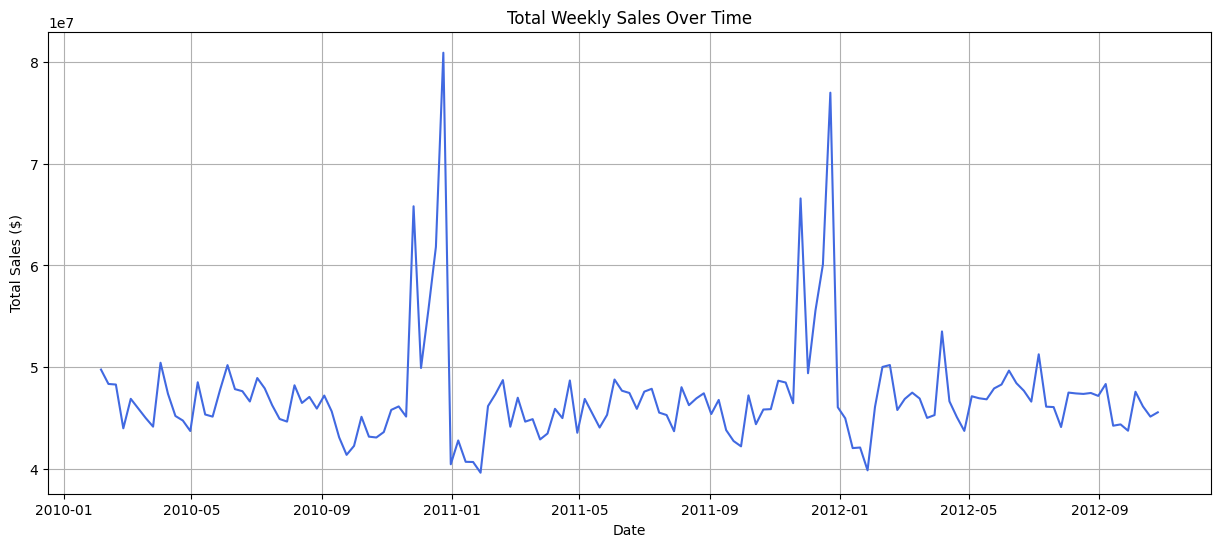

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'], color='royalblue')
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.grid(True)
plt.show()


## Store Level Performance

In [25]:
store_sales = train_full.groupby('Store')['Weekly_Sales'].sum().reset_index()
store_sales = store_sales.sort_values(by='Weekly_Sales', ascending=False)
store_sales.head()


,Store,Weekly_Sales
19,20,3.013978e+08
3,4,2.995440e+08
13,14,2.889999e+08
12,13,2.865177e+08
1,2,2.753824e+08


**Plot Total Sales by Store**

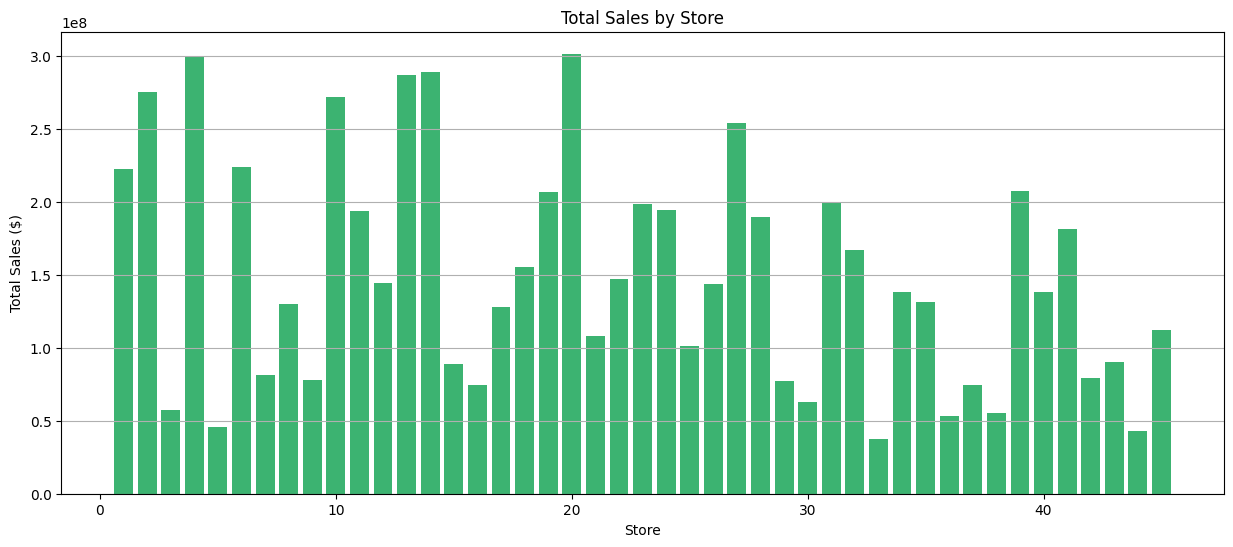

In [27]:
plt.figure(figsize=(15,6))
plt.bar(store_sales['Store'], store_sales['Weekly_Sales'], color='mediumseagreen')
plt.title('Total Sales by Store')
plt.xlabel('Store')
plt.ylabel('Total Sales ($)')
plt.grid(axis='y')
plt.show()


## Department Level Performance

In [29]:
dept_sales = train_full.groupby('Dept')['Weekly_Sales'].sum().reset_index()
dept_sales = dept_sales.sort_values(by='Weekly_Sales', ascending=False)
dept_sales.head()


,Dept,Weekly_Sales
73,92,4.839433e+08
76,95,4.493202e+08
36,38,3.931181e+08
60,72,3.057252e+08
71,90,2.910685e+08


**Plot Total Sales by Department**

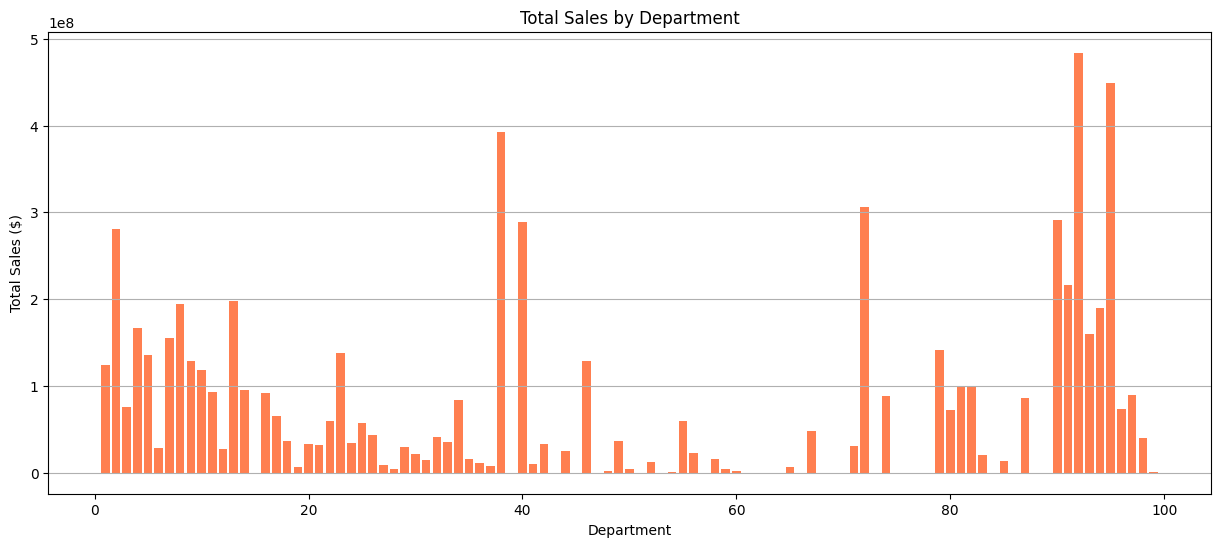

In [31]:
plt.figure(figsize=(15,6))
plt.bar(dept_sales['Dept'], dept_sales['Weekly_Sales'], color='coral')
plt.title('Total Sales by Department')
plt.xlabel('Department')
plt.ylabel('Total Sales ($)')
plt.grid(axis='y')
plt.show()


## Seasonality Check

In [33]:
train_full['Month'] = train_full['Date'].dt.month


In [34]:
monthly_sales = train_full.groupby('Month')['Weekly_Sales'].sum().reset_index()
monthly_sales


,Month,Weekly_Sales
0,1,3.325984e+08
1,2,5.687279e+08
2,3,5.927859e+08
3,4,6.468598e+08
4,5,5.571256e+08
5,6,6.226299e+08
6,7,6.500010e+08
7,8,6.130902e+08
8,9,5.787612e+08
9,10,5.847848e+08


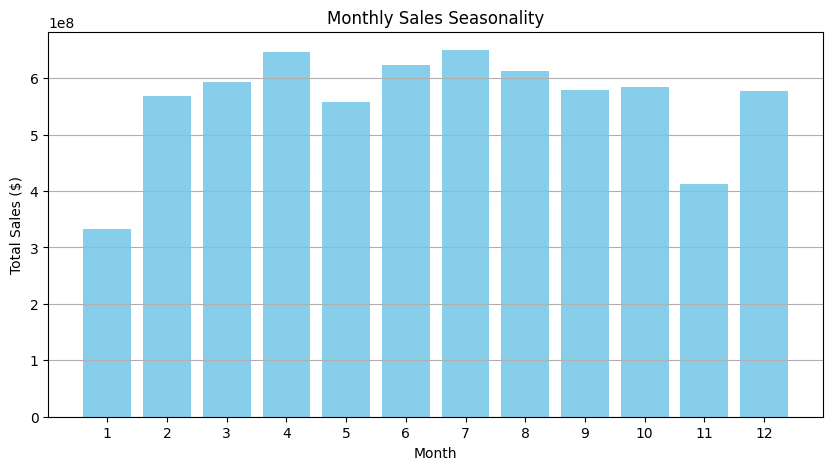

In [35]:
plt.figure(figsize=(10,5))
plt.bar(monthly_sales['Month'], monthly_sales['Weekly_Sales'], color='skyblue')
plt.title('Monthly Sales Seasonality')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.xticks(range(1,13))
plt.grid(axis='y')
plt.show()


In [36]:
train_full.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Month
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,2
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,2
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,2
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,3


## Cleaning and Feature Engineering

In [38]:
(train_full['IsHoliday_x'] == train_full['IsHoliday_y']).value_counts()


True    421570
dtype: int64

In [39]:
train_full['IsHoliday'] = train_full['IsHoliday_x']
train_full.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1, inplace=True)


## Holiday Sales Analysis

In [41]:
holiday_sales = train_full.groupby('IsHoliday')['Weekly_Sales'].sum().reset_index()
holiday_sales


,IsHoliday,Weekly_Sales
0,False,6.231919e+09
1,True,5.052996e+08


**Plot Holiday vs Non-Holiday Sales**

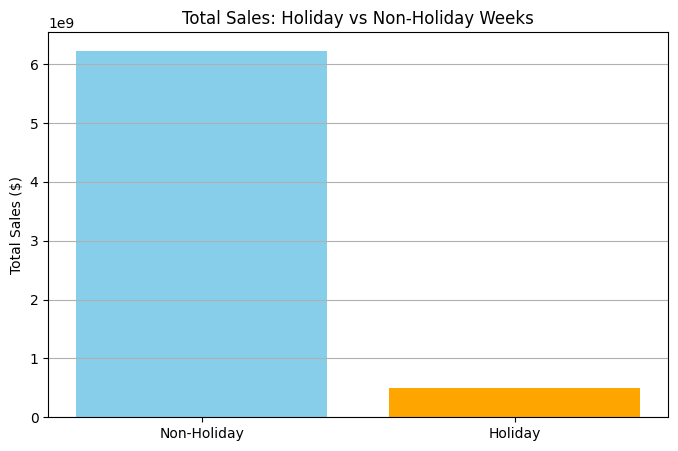

In [43]:
plt.figure(figsize=(8,5))
plt.bar(['Non-Holiday', 'Holiday'], holiday_sales['Weekly_Sales'], color=['skyblue', 'orange'])
plt.title('Total Sales: Holiday vs Non-Holiday Weeks')
plt.ylabel('Total Sales ($)')
plt.grid(axis='y')
plt.show()


## Holiday Mapping

In [45]:
# Full set of holiday dates within dataset (up to Oct 2012)
holiday_dict = {
    'Super Bowl': ['2010-02-12', '2011-02-11', '2012-02-10'],
    'Labor Day': ['2010-09-10', '2011-09-09', '2012-09-07'],
    'Thanksgiving': ['2010-11-26', '2011-11-25', '2012-11-23'],
    'Christmas': ['2010-12-31', '2011-12-30']
}

# Flattened holiday lookup
holiday_lookup = {}
for holiday, dates in holiday_dict.items():
    for date in dates:
        holiday_lookup[pd.to_datetime(date)] = holiday

# Map holiday names
train_full['Holiday_Name'] = train_full['Date'].map(holiday_lookup)
train_full['Holiday_Name'] = train_full['Holiday_Name'].fillna('Non-Holiday')


In [46]:
holiday_breakdown = train_full.groupby('Holiday_Name')['Weekly_Sales'].sum().reset_index()
holiday_breakdown


,Holiday_Name,Weekly_Sales
0,Christmas,8.647498e+07
1,Labor Day,1.407277e+08
2,Non-Holiday,6.231919e+09
3,Super Bowl,1.456823e+08
4,Thanksgiving,1.324146e+08


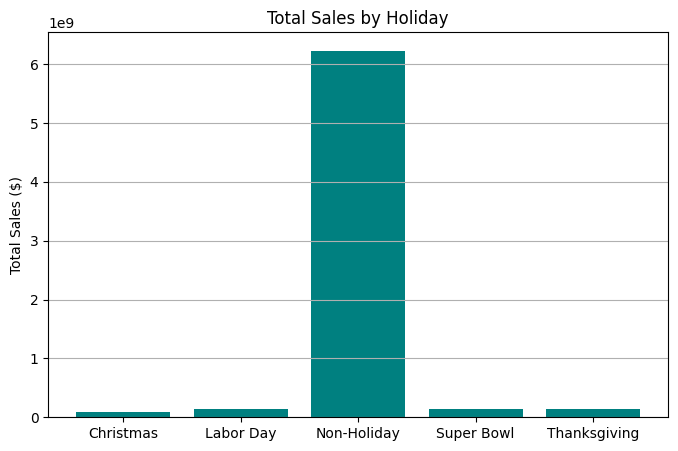

In [47]:
plt.figure(figsize=(8,5))
plt.bar(holiday_breakdown['Holiday_Name'], holiday_breakdown['Weekly_Sales'], color='teal')
plt.title('Total Sales by Holiday')
plt.ylabel('Total Sales ($)')
plt.grid(axis='y')
plt.show()


## Markdown Analysis

In [49]:
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
train_full[markdown_cols].isnull().sum()


MarkDown1    270889
MarkDown2    310322
MarkDown3    284479
MarkDown4    286603
MarkDown5    270138
dtype: int64

In [50]:
train_full[markdown_cols] = train_full[markdown_cols].fillna(0)


## Correlation of Markdown with Sales

In [52]:
corrs = train_full[markdown_cols + ['Weekly_Sales']].corr()['Weekly_Sales'].sort_values(ascending=False)
corrs


Weekly_Sales    1.000000
MarkDown5       0.050465
MarkDown1       0.047172
MarkDown3       0.038562
MarkDown4       0.037467
MarkDown2       0.020716
Name: Weekly_Sales, dtype: float64

## Visualizing Markdown Impact

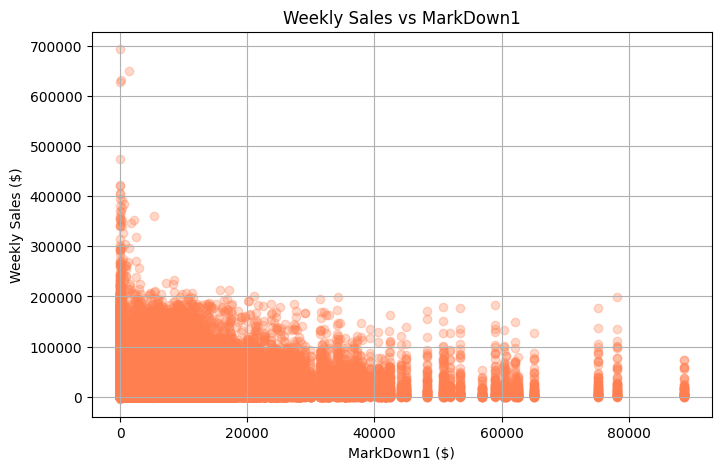

In [54]:
plt.figure(figsize=(8,5))
plt.scatter(train_full['MarkDown1'], train_full['Weekly_Sales'], alpha=0.3, color='coral')
plt.title('Weekly Sales vs MarkDown1')
plt.xlabel('MarkDown1 ($)')
plt.ylabel('Weekly Sales ($)')
plt.grid(True)
plt.show()


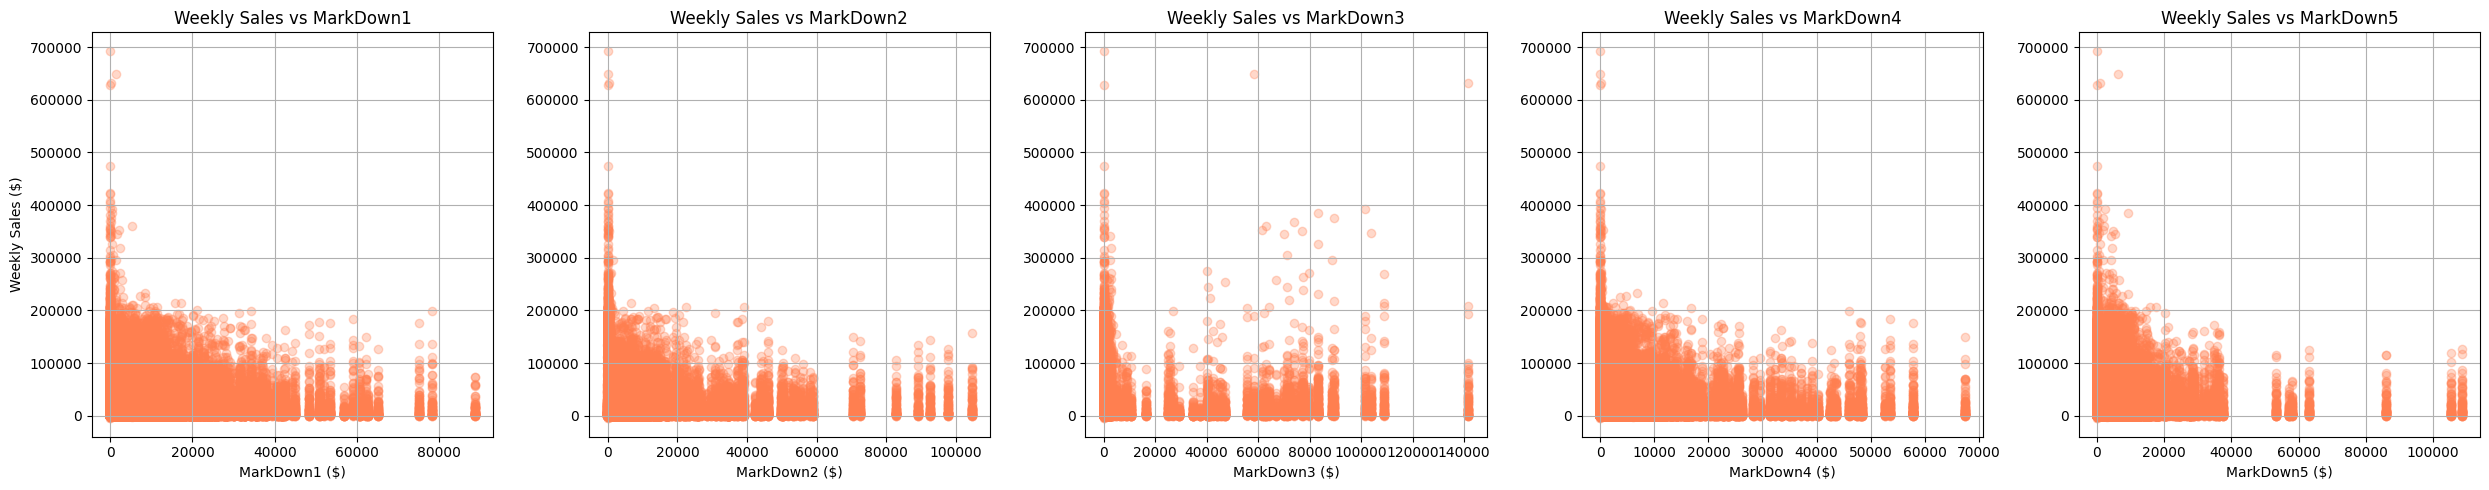

In [55]:
import matplotlib.pyplot as plt

# Set up grid for 5 subplots
fig, axs = plt.subplots(1, 5, figsize=(25,5))

# Loop through each MarkDown column
for i, col in enumerate(markdown_cols):
    axs[i].scatter(train_full[col], train_full['Weekly_Sales'], alpha=0.3, color='coral')
    axs[i].set_title(f'Weekly Sales vs {col}')
    axs[i].set_xlabel(f'{col} ($)')
    if i == 0:
        axs[i].set_ylabel('Weekly Sales ($)')
    axs[i].grid(True)

plt.tight_layout()
plt.show()


## Store Level Seasonality

In [57]:
store_weekly_sales = train_full.groupby(['Date', 'Store'])['Weekly_Sales'].sum().reset_index()


In [58]:
# Aggregate weekly sales across ALL stores and departments for forecasting
agg_df = train_full.groupby('Date')['Weekly_Sales'].sum().reset_index()
agg_df.set_index('Date', inplace=True)
sales_series = agg_df['Weekly_Sales']

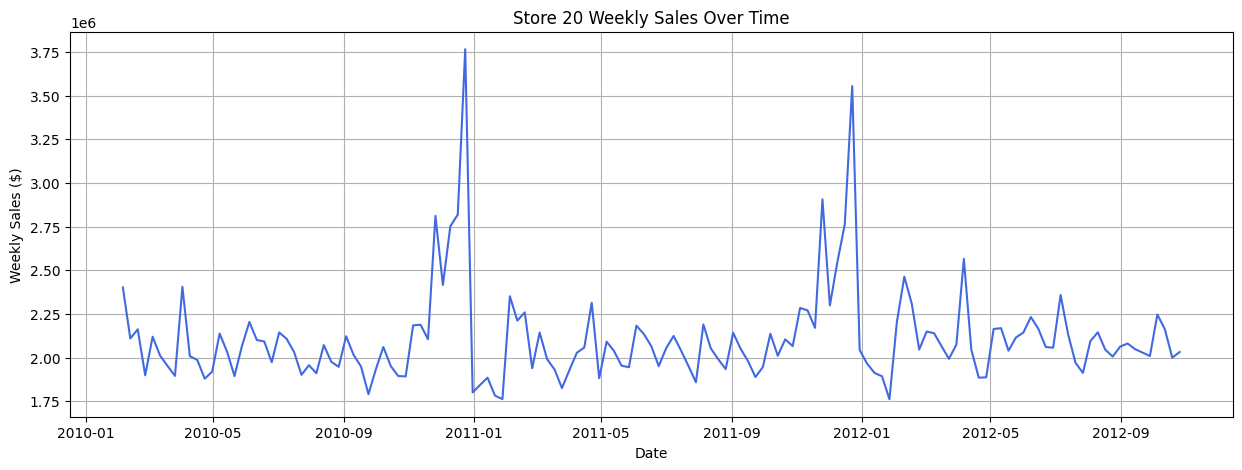

In [59]:
# Filter for Store 20
store20_sales = store_weekly_sales[store_weekly_sales['Store'] == 20]

plt.figure(figsize=(15,5))
plt.plot(store20_sales['Date'], store20_sales['Weekly_Sales'], color='royalblue')
plt.title('Store 20 Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales ($)')
plt.grid(True)
plt.show()


## Top 4 Stores Sales

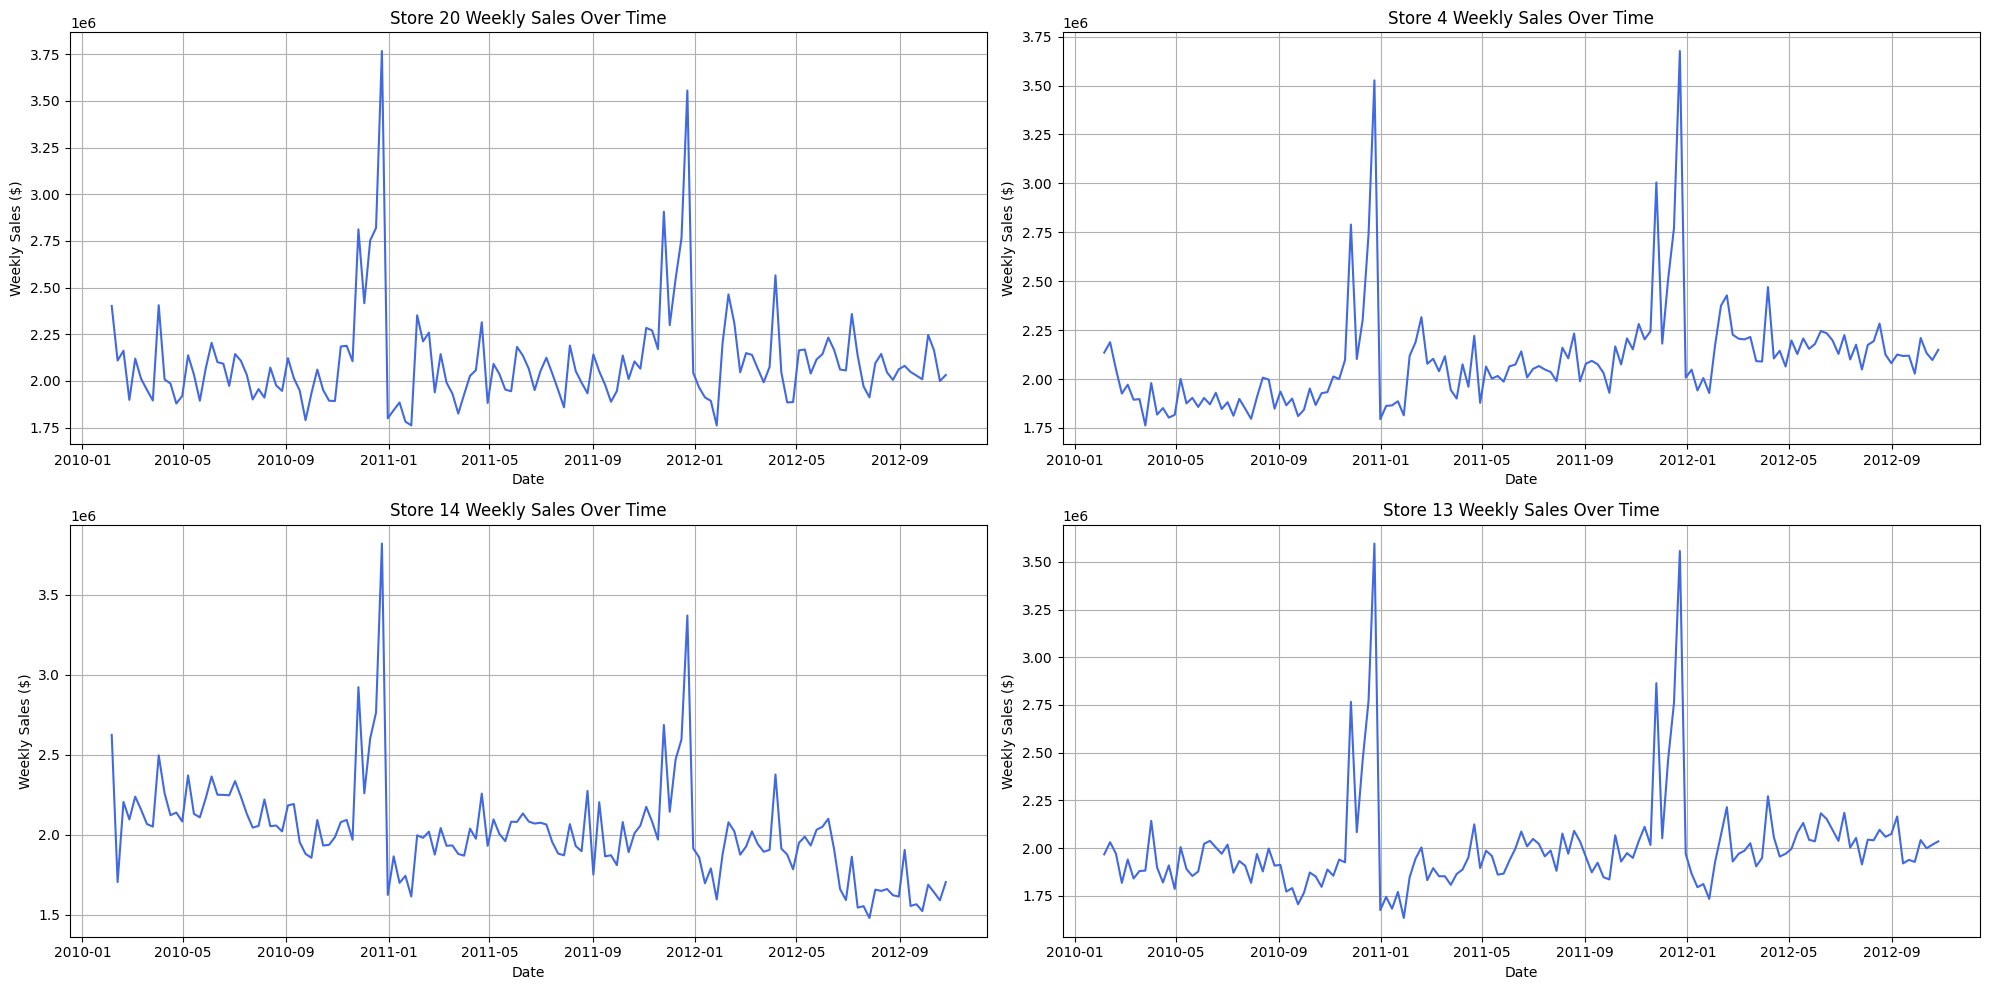

In [61]:
# Top store IDs
top_stores = [20, 4, 14, 13]

# Set up 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

for i, store_id in enumerate(top_stores):
    store_sales = store_weekly_sales[store_weekly_sales['Store'] == store_id]
    ax = axs[i//2, i%2]
    ax.plot(store_sales['Date'], store_sales['Weekly_Sales'], color='royalblue')
    ax.set_title(f'Store {store_id} Weekly Sales Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')
    ax.grid(True)

plt.tight_layout()
plt.show()


## Correlation Matrix

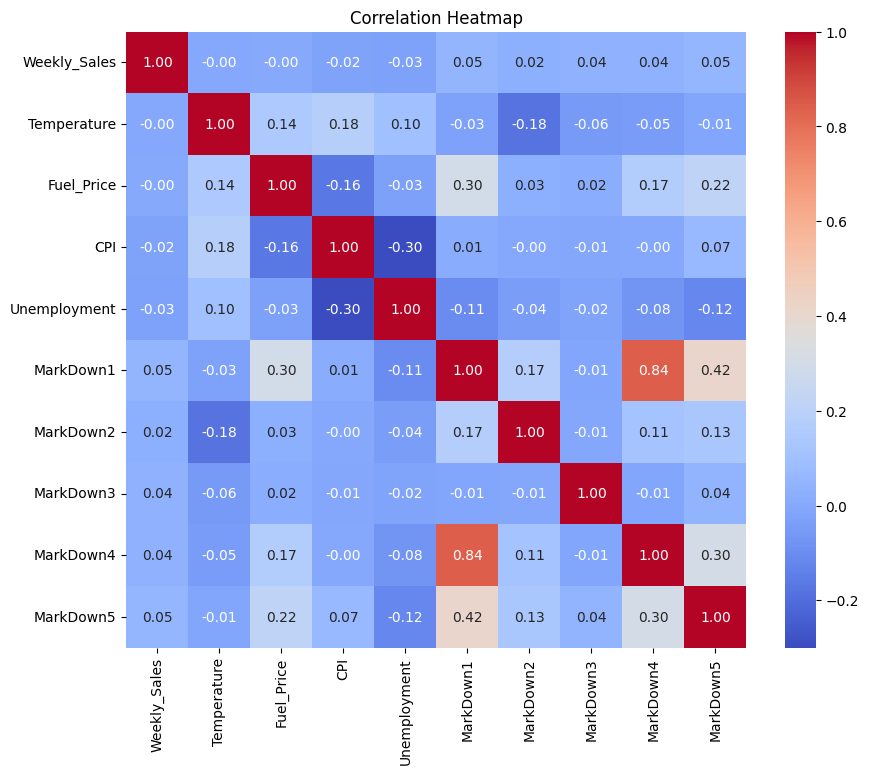

In [63]:
import seaborn as sns

# Subset only numeric columns
numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 
                 'CPI', 'Unemployment'] + markdown_cols

# Compute correlation matrix
corr_matrix = train_full[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()


## KPI Summary Table

In [65]:
total_sales = train_full['Weekly_Sales'].sum()
avg_sales_per_week = train_full.groupby('Date')['Weekly_Sales'].sum().mean()
num_weeks = train_full['Date'].nunique()
num_stores = train_full['Store'].nunique()
num_depts = train_full['Dept'].nunique()

print(f"Total Sales: ${total_sales:,.0f}")
print(f"Average Weekly Sales: ${avg_sales_per_week:,.0f}")
print(f"Total Weeks: {num_weeks}")
print(f"Total Stores: {num_stores}")
print(f"Total Departments: {num_depts}")


Total Sales: $6,737,218,987
Average Weekly Sales: $47,113,419
Total Weeks: 143
Total Stores: 45
Total Departments: 81


## Time Series Forecasting (ARIMA)

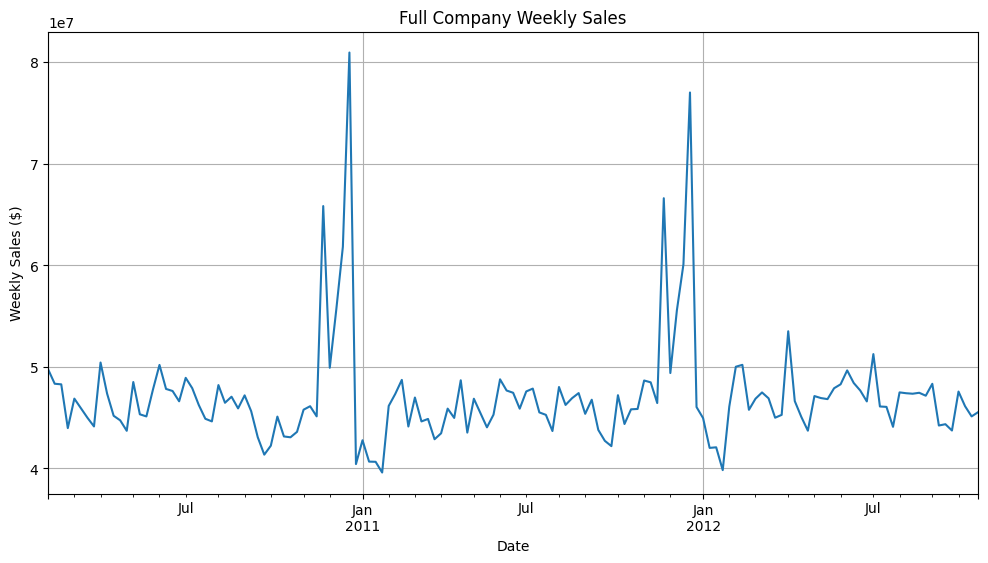

In [67]:
# Filter data for Store 20, Dept 92
#ts_data = train_full[(train_full['Store'] == 20) & (train_full['Dept'] == 92)].copy()

# Sort by date (just to be safe)
#ts_data = ts_data.sort_values('Date')

# Set Date as index
#ts_data.set_index('Date', inplace=True)

# Create weekly sales series
#sales_series = ts_data['Weekly_Sales']

# Display
sales_series.plot(figsize=(12,6), title='Full Company Weekly Sales', ylabel='Weekly Sales ($)')
plt.grid(True)
plt.show()


In [68]:
!pip install pmdarima


In [69]:
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX


## Auto ARIMA model selection

In [71]:
# Auto ARIMA to suggest orders
auto_model = pm.auto_arima(sales_series, seasonal=True, m=52, 
                           stepwise=True, suppress_warnings=True, information_criterion='aic')
print(auto_model.summary())


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  143
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood               -2376.907
Date:                             Tue, 17 Jun 2025   AIC                           4767.813
Time:                                     15:05:54   BIC                           4788.553
Sample:                                 02-05-2010   HQIC                          4776.241
                                      - 10-26-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.103e+07   1.59e-08   1.95e+15      0.000     3.1e+07     3.1e+07
ar.L1         -0.8263      

## Fit SARIMAX model

In [73]:
# Fit SARIMAX model using the parameters from auto_arima
model = SARIMAX(agg_df['Weekly_Sales'], order=(0,1,1), seasonal_order=(0,1,0,52))

results = model.fit()

print(results.summary())


C:\Users\adity\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\adity\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                        Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 52)   Log Likelihood               -1443.881
Date:                             Tue, 17 Jun 2025   AIC                           2891.762
Time:                                     15:05:54   BIC                           2896.762
Sample:                                 02-05-2010   HQIC                          2893.778
                                      - 10-26-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1412      0.024     -5.800      0.000      -0.189      -0.094
sigma2      4.089e+12   1.1

## Forecasting next 12 weeks

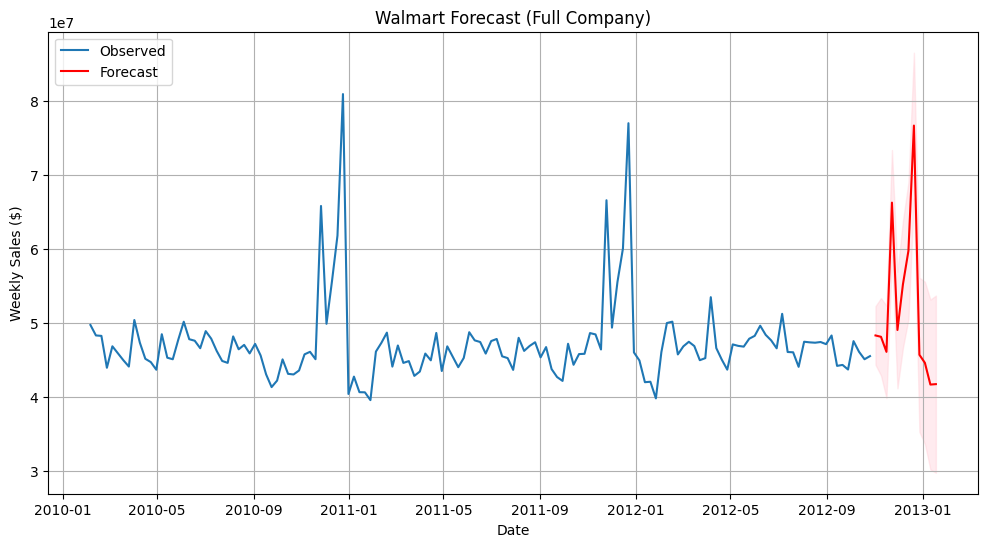

In [75]:
n_forecast = 12
forecast_result = results.get_forecast(steps=n_forecast)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()


# Generate forecast index
forecast_index = pd.date_range(start=sales_series.index[-1] + pd.Timedelta(weeks=1), periods=n_forecast, freq='W-FRI')


# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(sales_series, label='Observed')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Walmart Forecast (Full Company)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales ($)')
plt.legend()
plt.grid(True)
plt.show()


In [76]:
train_full.to_csv('walmart_cleaned_dataset.csv', index=False)


## Export Forecasts for Power BI

## Exporting Fully Cleaned and Merged Dataset

In [79]:
# Rebuild forecast_df properly using column names directly
forecast_df = pd.DataFrame({
    'Date': forecast_mean.index,
    'Forecast': forecast_mean.values,
    'Lower_CI': conf_int.iloc[:, 0].values,
    'Upper_CI': conf_int.iloc[:, 1].values
})

forecast_df['Weekly_Sales'] = 0
forecast_df = forecast_df[['Date', 'Weekly_Sales', 'Forecast', 'Lower_CI', 'Upper_CI']]


historical_df = agg_df.reset_index()
historical_df['Forecast'] = 0
historical_df['Lower_CI'] = 0
historical_df['Upper_CI'] = 0

final_forecast_df = pd.concat([historical_df, forecast_df], axis=0).sort_values('Date')


final_forecast_df.fillna(0, inplace=True)
final_forecast_df.to_csv('walmart_forecast_total.csv', index=False)



In [80]:
print(forecast_mean)
print(conf_int)


2012-11-02    4.833489e+07
2012-11-09    4.815357e+07
2012-11-16    4.611833e+07
2012-11-23    6.627295e+07
2012-11-30    4.906991e+07
2012-12-07    5.524050e+07
2012-12-14    5.976504e+07
2012-12-21    7.667759e+07
2012-12-28    4.572181e+07
2013-01-04    4.463477e+07
2013-01-11    4.170243e+07
2013-01-18    4.176035e+07
Freq: W-FRI, Name: predicted_mean, dtype: float64
            lower Weekly_Sales  upper Weekly_Sales
2012-11-02        4.437158e+07        5.229820e+07
2012-11-09        4.292943e+07        5.337771e+07
2012-11-16        3.988331e+07        5.235335e+07
2012-11-23        5.916949e+07        7.337642e+07
2012-11-30        4.119316e+07        5.694665e+07
2012-12-07        4.665989e+07        6.382111e+07
2012-12-14        5.053408e+07        6.899601e+07
2012-12-21        6.683917e+07        8.651601e+07
2012-12-28        3.531132e+07        5.613230e+07
2013-01-04        3.368205e+07        5.558749e+07
2013-01-11        3.023308e+07        5.317178e+07
2013-01-18    

In [81]:
print(forecast_mean.index)
print(forecast_index)
print(len(forecast_mean))
print(len(forecast_index))


DatetimeIndex(['2012-11-02', '2012-11-09', '2012-11-16', '2012-11-23',
               '2012-11-30', '2012-12-07', '2012-12-14', '2012-12-21',
               '2012-12-28', '2013-01-04', '2013-01-11', '2013-01-18'],
              dtype='datetime64[ns]', freq='W-FRI')
DatetimeIndex(['2012-11-02', '2012-11-09', '2012-11-16', '2012-11-23',
               '2012-11-30', '2012-12-07', '2012-12-14', '2012-12-21',
               '2012-12-28', '2013-01-04', '2013-01-11', '2013-01-18'],
              dtype='datetime64[ns]', freq='W-FRI')
12
12


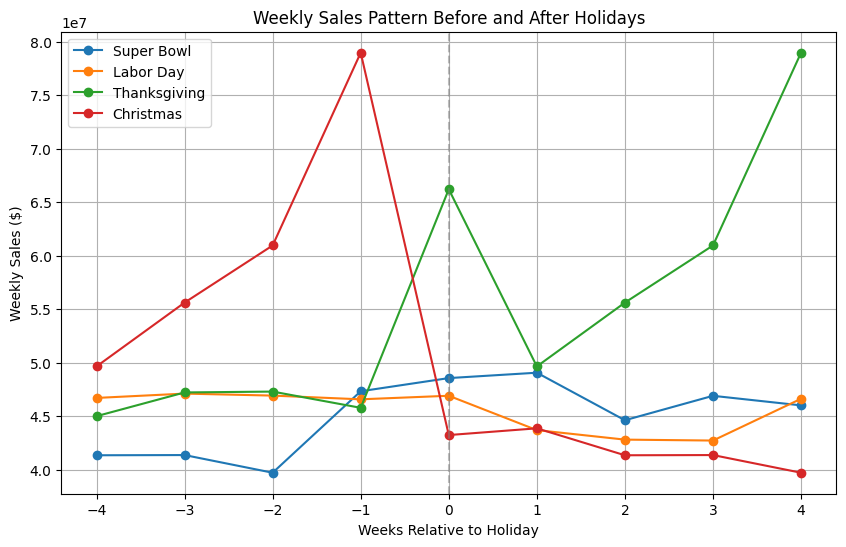

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Make sure Date column is datetime if not already
train_full['Date'] = pd.to_datetime(train_full['Date'])

# Create a holiday mapping based on Kaggle provided dates
holiday_dates = {
    'Super Bowl': ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'],
    'Labor Day': ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'],
    'Thanksgiving': ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'],
    'Christmas': ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']
}

# Aggregate sales by Date
agg_sales = train_full.groupby('Date')['Weekly_Sales'].sum().reset_index()
agg_sales.set_index('Date', inplace=True)

# Create aligned data windows for each holiday
window_range = range(-4, 5)  # 4 weeks before and after
holiday_windows = {}

for holiday, dates in holiday_dates.items():
    windows = []
    for d in dates:
        holiday_date = pd.to_datetime(d)
        window = []
        for offset in window_range:
            target_date = holiday_date + pd.Timedelta(weeks=offset)
            sales = agg_sales['Weekly_Sales'].get(target_date, np.nan)
            window.append(sales)
        windows.append(window)
    holiday_windows[holiday] = pd.DataFrame(windows, columns=window_range)

# Compute averages across holiday years
holiday_avg = {h: df.mean() for h, df in holiday_windows.items()}

# Plotting
plt.figure(figsize=(10,6))
for holiday, avg_series in holiday_avg.items():
    plt.plot(window_range, avg_series, marker='o', label=holiday)

plt.axvline(0, color='grey', linestyle='--', alpha=0.5)
plt.title("Weekly Sales Pattern Before and After Holidays")
plt.xlabel("Weeks Relative to Holiday")
plt.ylabel("Weekly Sales ($)")
plt.legend()
plt.grid(True)
plt.show()


## SQL Analytics

In [139]:
# Load original combined dataset
df = train_full.copy()

# Create 'sales' table
sales_df = df[['Date', 'Store', 'Dept', 'Weekly_Sales', 'IsHoliday']]
sales_df.to_csv('sales.csv', index=False)

# Create 'stores' table (drop duplicates)
stores_df = df[['Store', 'Type', 'Size']].drop_duplicates()
stores_df.to_csv('stores.csv', index=False)

# Create 'features' table
features_df = df[['Date', 'Store', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
                  'Temperature', 'Fuel_Price']]
features_df.to_csv('features.csv', index=False)


## Load CSVs into SQLite

In [142]:
import sqlite3
import pandas as pd

# Load CSVs
sales_df = pd.read_csv('sales.csv')
stores_df = pd.read_csv('stores.csv')
features_df = pd.read_csv('features.csv')

# Create SQLite connection
conn = sqlite3.connect('walmart_db.sqlite')

# Write to database
sales_df.to_sql('sales', conn, if_exists='replace', index=False)
stores_df.to_sql('stores', conn, if_exists='replace', index=False)
features_df.to_sql('features', conn, if_exists='replace', index=False)

# Confirm tables
print(conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall())


[('sales',), ('stores',), ('features',)]


## Count Sales Records

In [145]:
# Count number of rows in sales table
count = conn.execute("SELECT COUNT(*) FROM sales").fetchone()[0]
print("Total rows in sales table:", count)

# Preview sample rows
preview = pd.read_sql_query("SELECT * FROM sales LIMIT 5;", conn)
print(preview)


Total rows in sales table: 421570
         Date  Store  Dept  Weekly_Sales  IsHoliday
0  2010-02-05      1     1      24924.50          0
1  2010-02-12      1     1      46039.49          1
2  2010-02-19      1     1      41595.55          0
3  2010-02-26      1     1      19403.54          0
4  2010-03-05      1     1      21827.90          0


## SQL KPI Query

In [148]:
query = """
SELECT
  COUNT(DISTINCT Store) AS total_stores,
  COUNT(DISTINCT Dept) AS total_departments,
  ROUND(SUM(Weekly_Sales)/1e9, 2) AS total_sales_billion,
  ROUND(AVG(Weekly_Sales), 2) AS avg_weekly_sales
FROM sales;
"""

kpi_df = pd.read_sql_query(query, conn)
kpi_df


,total_stores,total_departments,total_sales_billion,avg_weekly_sales
0,45,81,6.74,15981.26


## Holiday vs Non-Holiday Sales

In [151]:
query = """
SELECT 
  IsHoliday,
  ROUND(AVG(Weekly_Sales), 2) AS avg_sales,
  ROUND(SUM(Weekly_Sales)/1e9, 2) AS total_sales_billion
FROM sales
GROUP BY IsHoliday;
"""

holiday_sales_df = pd.read_sql_query(query, conn)
holiday_sales_df


,IsHoliday,avg_sales,total_sales_billion
0,0,15901.45,6.23
1,1,17035.82,0.51


## Markdown vs Weekly Sales (Correlation Insight)

In [154]:
query = """
SELECT 
  f.Store,
  ROUND(AVG(f.MarkDown5), 2) AS avg_md5,
  ROUND(AVG(s.Weekly_Sales), 2) AS avg_sales
FROM features f
JOIN sales s 
  ON f.Store = s.Store AND f.Date = s.Date
WHERE f.MarkDown5 IS NOT NULL
GROUP BY f.Store
ORDER BY avg_md5 DESC;
"""

markdown_df = pd.read_sql_query(query, conn)
markdown_df.head()


,Store,avg_md5,avg_sales
0,39,6732.87,21003.66
1,31,2744.22,19681.77
2,13,2592.21,27359.76
3,28,2494.83,18723.46
4,4,2455.42,29160.40


## Top 5 Stores by Total Sales

In [156]:
query = """
SELECT 
  Store,
  ROUND(SUM(Weekly_Sales)/1e6, 2) AS total_sales_million
FROM sales
GROUP BY Store
ORDER BY total_sales_million DESC
LIMIT 5;
"""

top_stores_df = pd.read_sql_query(query, conn)
top_stores_df


,Store,total_sales_million
0,20,301.40
1,4,299.54
2,14,289.00
3,13,286.52
4,2,275.38
